In [2]:
!gdown --id 1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 48.0MB/s]


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [27]:
dataset = pd.read_csv('/content/Auto_MPG_data.csv')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [35]:
train_dataset = dataset.sample(frac=0.8,random_state=1)
val_dataset = dataset.drop(train_dataset.index)

In [36]:
X_train = train_dataset.copy()
X_val = val_dataset.copy()
y_train = X_train.pop('MPG')
y_val = X_val.pop('MPG')

X_train, y_train = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)

In [37]:
_MEAN = X_train.mean(axis=0)
_STD = X_train.std(axis=0)

X_train = (X_train - _MEAN)/_STD
X_val = (X_val - _MEAN)/_STD

In [38]:
class CustomDataset(nn.Module):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.y)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [39]:
class LinearRegression(nn.Module):
  def __init__(self, input_dims, output_dims):
    super().__init__()
    self.fc = nn.Linear(input_dims, output_dims)
  def forward(self, x):
    x = self.fc(x)
    return x

model = LinearRegression(input_dims=9, output_dims=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [40]:
def r_squared(y_true, y_pred):
    """
    Compute R^2 score.
    """
    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [41]:
num_epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  train_target = []
  val_target = []
  train_predict = []
  val_predict = []
  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    outputs = model(X)
    train_predict.extend(outputs.tolist())
    train_target.extend(y.tolist())
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_r2.append(r_squared(train_target, train_predict))
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for X, y in val_loader:
      X, y = X.to(device), y.to(device)
      outputs = model(X)
      val_predict.extend(outputs.tolist())
      val_target.extend(y.tolist())
      loss = criterion(outputs, y)
      val_loss += loss.item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_r2.append(r_squared(val_target, val_predict))
  print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Validation Loss: {val_loss:.4f}")

Epoch 1/100, Train_Loss: 221.7728,  Validation Loss: 63.1769
Epoch 2/100, Train_Loss: 65.5797,  Validation Loss: 49.7546
Epoch 3/100, Train_Loss: 63.2627,  Validation Loss: 48.0446
Epoch 4/100, Train_Loss: 63.4249,  Validation Loss: 46.2533
Epoch 5/100, Train_Loss: 63.9122,  Validation Loss: 47.9731
Epoch 6/100, Train_Loss: 62.9457,  Validation Loss: 49.1758
Epoch 7/100, Train_Loss: 63.1103,  Validation Loss: 47.1176
Epoch 8/100, Train_Loss: 63.8394,  Validation Loss: 47.5545
Epoch 9/100, Train_Loss: 63.8239,  Validation Loss: 44.9224
Epoch 10/100, Train_Loss: 62.9617,  Validation Loss: 49.7849
Epoch 11/100, Train_Loss: 63.3184,  Validation Loss: 48.8024
Epoch 12/100, Train_Loss: 63.1278,  Validation Loss: 48.4563
Epoch 13/100, Train_Loss: 63.3945,  Validation Loss: 47.8030
Epoch 14/100, Train_Loss: 63.8709,  Validation Loss: 48.2355
Epoch 15/100, Train_Loss: 63.5782,  Validation Loss: 48.6120
Epoch 16/100, Train_Loss: 63.2667,  Validation Loss: 49.5019
Epoch 17/100, Train_Loss: 64.293

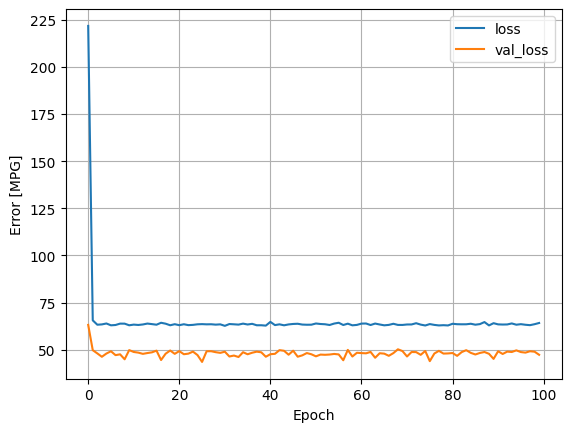

In [42]:
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

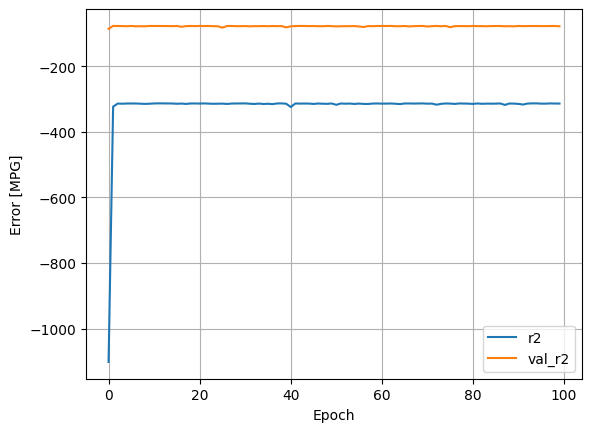

In [43]:
plt.plot(train_r2, label='r2')
plt.plot(val_r2, label='val_r2')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)